<a href="https://colab.research.google.com/github/Cheolwoong1111/PINN/blob/main/2D_Linear_elastic_cantilever_beam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the Physics-informed neural network code for 2D linear elastic problem.


In [18]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pdb # use 'pdb.set_trace()' where you want to see

torch.manual_seed(2222)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Command description ('pdb.set_trace()')

1. list Show the current location in the file

2. h(elp) Show a list of commands, or find help on a specific command

3. q(uit) Quit the debugger and the program

4. c(ontinue) Quit the debugger, continue in the program

5. n(ext) Go to the next step of the program

6. Repeat the previous command

7. p(rint) Print variables

8. s(tep) Step into a subroutine

9. r(eturn) Return out of a subroutine

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        n_input = 2
        n_output = 1 
        n_nodes = 30

        self.hidden_layer1 = nn.Linear(n_input,n_nodes)
        nn.init.xavier_uniform_(self.hidden_layer1.weight)
        nn.init.normal_(self.hidden_layer1.bias)

        self.hidden_layer2 = nn.Linear(n_nodes,n_nodes)
        nn.init.xavier_uniform_(self.hidden_layer2.weight)
        nn.init.normal_(self.hidden_layer2.bias)

        self.hidden_layer3 = nn.Linear(n_nodes,n_nodes)
        nn.init.xavier_uniform_(self.hidden_layer3.weight)
        nn.init.normal_(self.hidden_layer3.bias)

        self.hidden_layer4 = nn.Linear(n_nodes,n_nodes)
        nn.init.xavier_uniform_(self.hidden_layer4.weight)
        nn.init.normal_(self.hidden_layer4.bias)

        self.hidden_layer5 = nn.Linear(n_nodes,n_nodes)
        nn.init.xavier_uniform_(self.hidden_layer5.weight)
        nn.init.normal_(self.hidden_layer5.bias)

        self.hidden_layer6 = nn.Linear(n_nodes,n_nodes)
        nn.init.xavier_uniform_(self.hidden_layer6.weight)
        nn.init.normal_(self.hidden_layer6.bias)

        self.output_layer = nn.Linear(n_nodes, n_output)
        nn.init.xavier_uniform_(self.output_layer.weight)
        nn.init.normal_(self.output_layer.bias)

    def forward(self, x,y):
        inputs = torch.cat([x,y],axis=1)

        layer1_out = torch.tanh(self.hidden_layer1(inputs))
        layer2_out = torch.tanh(self.hidden_layer2(layer1_out))
        layer3_out = torch.tanh(self.hidden_layer3(layer2_out))
        layer4_out = torch.tanh(self.hidden_layer4(layer3_out))
        layer5_out = torch.tanh(self.hidden_layer5(layer4_out))
        layer6_out = torch.tanh(self.hidden_layer6(layer5_out))

        output = self.output_layer(layer6_out) ## For regression, no activation is used in output layer
        return output

In [20]:
def pinnLoss(x,y, mse, net_u, net_v):

    u = net_u(x,y) 
    v = net_v(x,y)

    E = 1
    nu = 0.3

    lmbd = E * nu/((1+nu)*(1-2*nu))
    mu = E/(2*(1+nu)) 
    
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_y = torch.autograd.grad(u.sum(), y, create_graph=True)[0]
    v_x = torch.autograd.grad(v.sum(), x, create_graph=True)[0]
    v_y = torch.autograd.grad(v.sum(), y, create_graph=True)[0]
    
    exx = u_x
    eyy = v_y
    exy = 1/2*(u_y + v_x)
      
    sxx = (lmbd+2*mu)*exx + lmbd*eyy
    syy = (lmbd+2*mu)*eyy + lmbd*exx
    sxy = 2*mu*exy
    
    sxx_x = torch.autograd.grad(sxx.sum(), x, create_graph=True)[0]
    sxy_x = torch.autograd.grad(sxy.sum(), x, create_graph=True)[0]
    sxy_y = torch.autograd.grad(sxy.sum(), y, create_graph=True)[0]
    syy_y = torch.autograd.grad(syy.sum(), y, create_graph=True)[0]
    
    Fx = (sxx_x + sxy_y)
    Fy = (sxy_x + syy_y)
    
    mse_losspde= mse(Fx, torch.zeros_like(x)) + mse(Fy, torch.zeros_like(x))

    
    return mse_losspde, u, v, sxx, sxy, syy
    

In [21]:
def dataPoints(x0,y0,x1,y1,nx,ny,densBnd):

    x = np.linspace(x0,x1,num = nx)
    y = np.linspace(y0,y1,num = ny)

    X, Y = np.meshgrid(x,y)

    xi = X[1:-1,1:-1].reshape(-1,1)
    yi = Y[1:-1,1:-1].reshape(-1,1)
    
    xb = np.linspace(x0,x1,num = densBnd * nx)
    yb = np.linspace(y0,y1,num = densBnd * ny)
    Xb, Yb = np.meshgrid(xb,yb)
    xb = np.hstack((Xb[:,0], Xb[-1,:],Xb[:,-1],Xb[0,:])).reshape(-1,1)
    yb = np.hstack((Yb[:,0], Yb[-1,:],Yb[:,-1],Yb[0,:])).reshape(-1,1)
    xt = np.vstack((xb,xi))
    yt = np.vstack((yb,yi))

    fig = plt.figure(figsize=(10,10))
    plt.scatter(xb,yb,s=2)
    plt.scatter(xi,yi,s=2)
    plt.show

    return xt, yt

In [22]:
def boundaryPointsCantilever(x,y,x0,y0,x1,y1):

    Lx = x1 - x0
    Ly = y1 - y0

    # x = 0
    idxLeft = torch.where(x==x0)

    # x = Lx
    idxRightFree = torch.where((x==x1) & (((y > y0) & (y < (y1+y0)/2 - Ly/10 )) | ((y < y1) & (y > (y1+y0)/2 + Ly/10 ))))
    idxRightLoad = torch.where((x==x1) & ((y> (y1+y0)/2 - Ly/10) & (y< (y1+y0)/2 + Ly/10 )))

    # y = 0
    idxBot = torch.where(y==y0)

    # y = Ly
    idxTop = torch.where(y==y1)

    return idxLeft, idxBot, idxTop, idxRightFree, idxRightLoad

In [23]:
def boundaryLoss(f, x, y, x0, y0, x1,y1, mse, net_u, net_v):

    xL = x[idxLeft].view(-1,1)
    yL = y[idxLeft].view(-1,1)
    _, u_xL, v_xl, _, _, _ = pinnLoss(xL, yL, mse, net_u, net_v)
    
    xT = x[idxTop].view(-1,1)
    yT = y[idxTop].view(-1,1)
    _, _, _, _, sxy_xT, syy_xT = pinnLoss(xT,yT, mse, net_u, net_v)
    
    xB = x[idxBot].view(-1,1)
    yB = y[idxBot].view(-1,1)
    _, _, _, _, sxy_xB, syy_xB = pinnLoss(xB,yB, mse, net_u, net_v)
    
    xRF = x[idxRightFree].view(-1,1)
    yRF = y[idxRightFree].view(-1,1)
    _, _, _, sxx_RF, sxy_RF, _ = pinnLoss(xRF,yRF, mse, net_u, net_v)
    
    xRL = x[idxRightLoad].view(-1,1)
    yRL = y[idxRightLoad].view(-1,1)
    _, _, _, sxx_RL, sxy_RL, _ = pinnLoss(xRL,yRL, mse, net_u, net_v)
    
    # fig = plt.figure(figsize=(4,3))
    # plt.scatter(xL.cpu().detach().numpy(),yL.cpu().detach().numpy())
    # plt.scatter(xT.cpu().detach().numpy(),yT.cpu().detach().numpy())
    # plt.scatter(xB.cpu().detach().numpy(),yB.cpu().detach().numpy())
    # plt.scatter(xRF.cpu().detach().numpy(),yRF.cpu().detach().numpy())
    # plt.scatter(xRL.cpu().detach().numpy(),yRL.cpu().detach().numpy())
    # plt.show()
    
    net_bc_left_u_free = u_xL.view(-1,1)
    net_bc_left_v_free = v_xl.view(-1,1) 
    
    net_bc_top_syy_free = syy_xT.view(-1,1) 
    net_bc_top_sxy_free = sxy_xT.view(-1,1) 
    
    net_bc_bot_syy_free = syy_xB.view(-1,1) 
    net_bc_bot_sxy_free = sxy_xB.view(-1,1) 
    
    net_bc_right_sxx_free = sxx_RF.view(-1,1)
    net_bc_right_sxy_free = sxy_RF.view(-1,1) 
    
    net_bc_right_sxx_load = sxx_RL.view(-1,1) 
    net_bc_right_sxy_load = sxy_RL.view(-1,1) 
    
    mse_bc_left_u = mse(net_bc_left_u_free, torch.zeros_like(net_bc_left_u_free))
    mse_bc_left_v = mse(net_bc_left_v_free, torch.zeros_like(net_bc_left_u_free))
     
    mse_bc_top_syy = mse(net_bc_top_syy_free, torch.zeros_like(net_bc_top_syy_free))
    mse_bc_top_sxy = mse(net_bc_top_sxy_free, torch.zeros_like(net_bc_top_sxy_free))
     
    mse_bc_bot_syy = mse(net_bc_bot_syy_free, torch.zeros_like(net_bc_bot_syy_free))
    mse_bc_bot_sxy = mse(net_bc_bot_sxy_free, torch.zeros_like(net_bc_bot_sxy_free))
    
    mse_bc_right_sxx_free = mse(net_bc_right_sxx_free, torch.zeros_like(net_bc_right_sxx_free))
    mse_bc_right_sxy_free = mse(net_bc_right_sxy_free, torch.zeros_like(net_bc_right_sxy_free))
    
    mse_bc_right_sxx_load = mse(net_bc_right_sxx_load, torch.zeros_like(net_bc_right_sxx_load))
    mse_bc_right_sxy_load = mse(net_bc_right_sxy_load, f*torch.ones_like(net_bc_right_sxy_load))
    
    mse_lossbc = (mse_bc_left_u + mse_bc_left_v
            + mse_bc_top_syy + mse_bc_top_sxy
            + mse_bc_bot_syy + mse_bc_bot_sxy
            + mse_bc_right_sxx_free + mse_bc_right_sxy_free
            + mse_bc_right_sxx_load + mse_bc_right_sxy_load)
    
    return mse_lossbc

# Main code

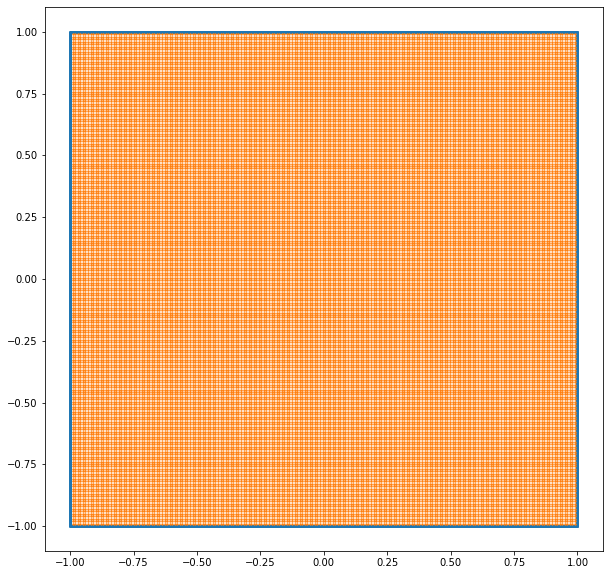

In [24]:
x0 = -1
y0 = -1
x1 = 1
y1 = 1
f = -0.1 # load

nx = 200      # Points for x-axis
ny = 200      # Points for y-axis
densBnd = 10   # Distribution density of points on boundaries

xnp, ynp = dataPoints(x0,y0,x1,y1,nx,ny,densBnd)

In [25]:
x = torch.tensor(xnp, dtype = torch.float32, requires_grad = True).to(device)
y = torch.tensor(ynp, dtype = torch.float32, requires_grad = True).to(device)

idxLeft, idxBot, idxTop, idxRightFree, idxRightLoad = boundaryPointsCantilever(x,y,x0,y0,x1,y1)

net_u = Net().to(device)
net_v = Net().to(device)

num_epochs = 10000
lr = 0.001
mse = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(list(net_u.parameters()) + list(net_v.parameters()), lr = lr)

history = np.zeros((0,2))

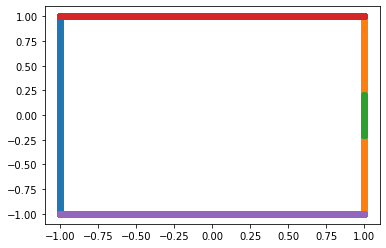

In [26]:
xll = x[idxLeft].detach().cpu().numpy().reshape(-1,1)
yll = y[idxLeft].detach().cpu().numpy().reshape(-1,1)
plt.scatter(xll,yll)

xrr = x[idxRightFree].detach().cpu().numpy().reshape(-1,1)
yrr = y[idxRightFree].detach().cpu().numpy().reshape(-1,1)
plt.scatter(xrr,yrr)

xrr1 = x[idxRightLoad].detach().cpu().numpy().reshape(-1,1)
yrr1 = y[idxRightLoad].detach().cpu().numpy().reshape(-1,1)
plt.scatter(xrr1,yrr1)

xtt = x[idxTop].detach().cpu().numpy().reshape(-1,1)
ytt = y[idxTop].detach().cpu().numpy().reshape(-1,1)
plt.scatter(xtt,ytt)

xbb = x[idxBot].detach().cpu().numpy().reshape(-1,1)
ybb = y[idxBot].detach().cpu().numpy().reshape(-1,1)
plt.scatter(xbb,ybb)

plt.show()

1000 Traning Loss: 0.0036374018527567387
PDE Loss: 8.5320e-04, BC Loss: 2.7842e-03


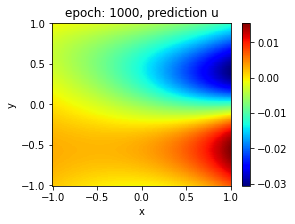

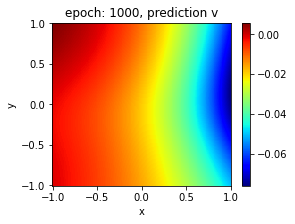

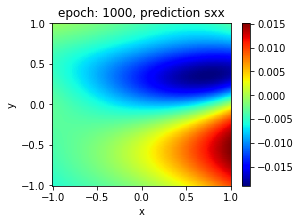

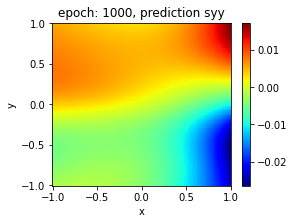

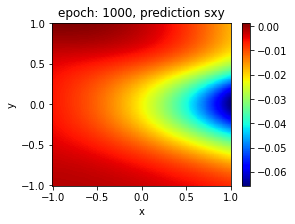

2000 Traning Loss: 0.002102439757436514
PDE Loss: 4.6688e-04, BC Loss: 1.6356e-03


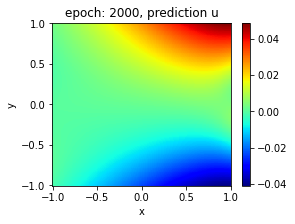

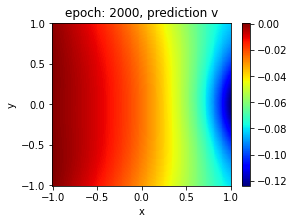

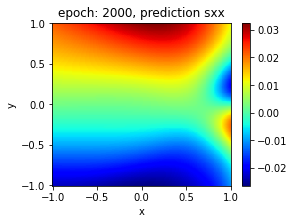

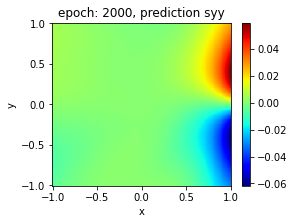

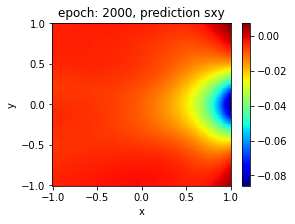

3000 Traning Loss: 0.0010764169273898005
PDE Loss: 2.0640e-04, BC Loss: 8.7002e-04


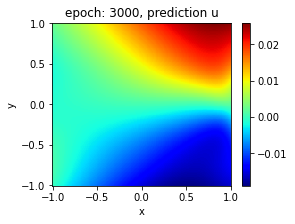

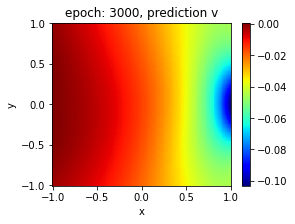

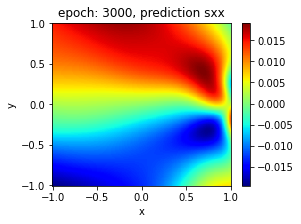

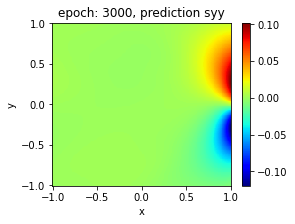

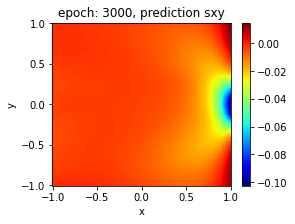

4000 Traning Loss: 0.0008676955476403236
PDE Loss: 1.4887e-04, BC Loss: 7.1883e-04


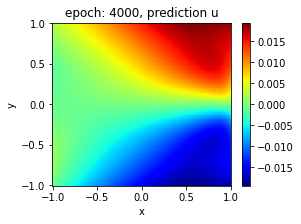

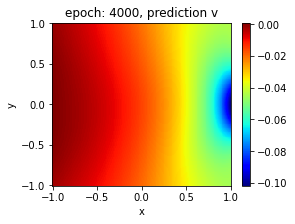

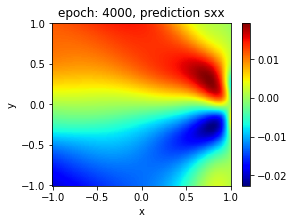

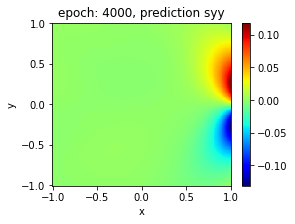

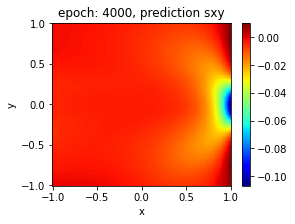

5000 Traning Loss: 0.0009880815632641315
PDE Loss: 1.9626e-04, BC Loss: 7.9182e-04


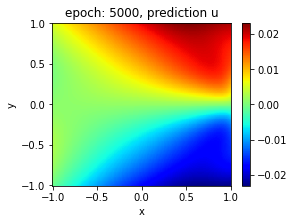

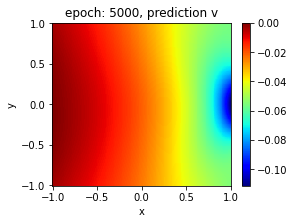

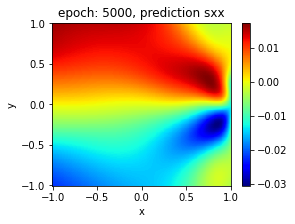

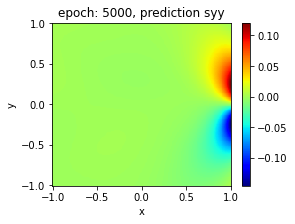

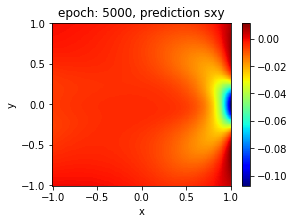

6000 Traning Loss: 0.000737018242944032
PDE Loss: 9.9627e-05, BC Loss: 6.3739e-04


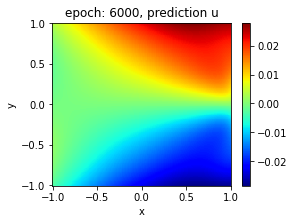

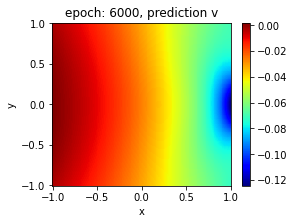

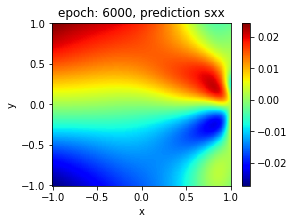

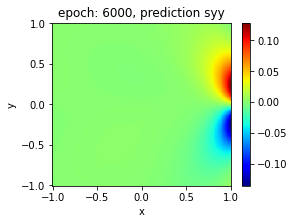

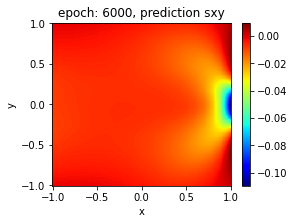

7000 Traning Loss: 0.0007033000001683831
PDE Loss: 8.9638e-05, BC Loss: 6.1366e-04


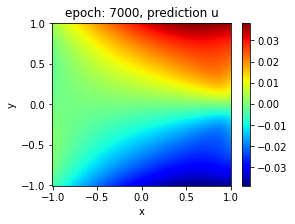

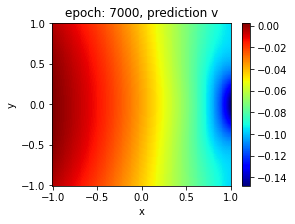

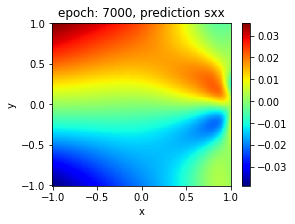

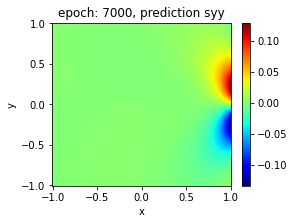

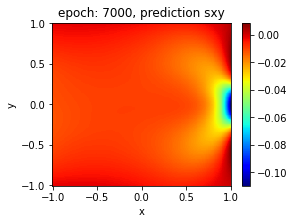

8000 Traning Loss: 0.0007523762760683894
PDE Loss: 1.0388e-04, BC Loss: 6.4849e-04


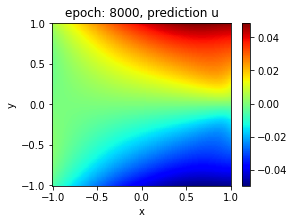

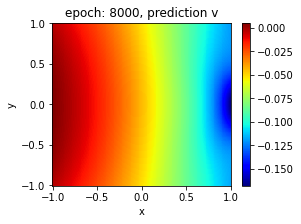

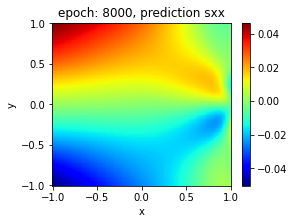

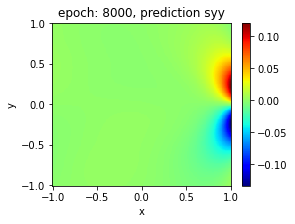

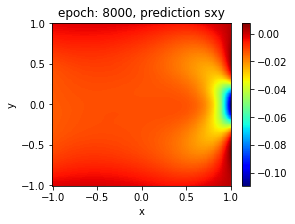

9000 Traning Loss: 0.0006296507199294865
PDE Loss: 6.3993e-05, BC Loss: 5.6566e-04


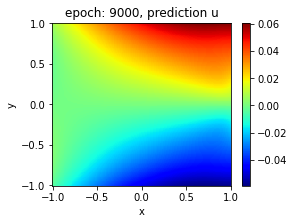

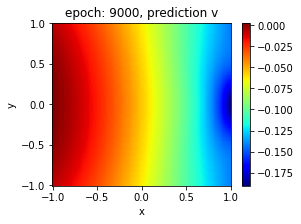

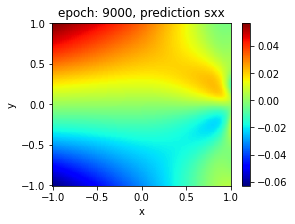

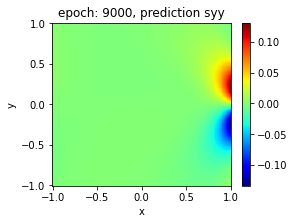

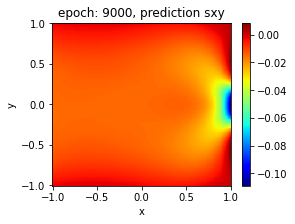

10000 Traning Loss: 0.0007324469042941928
PDE Loss: 9.0064e-05, BC Loss: 6.4238e-04


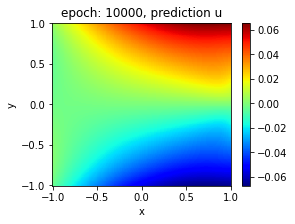

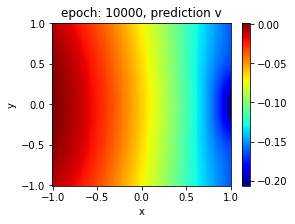

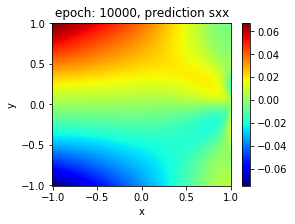

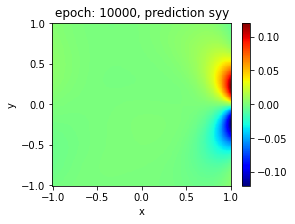

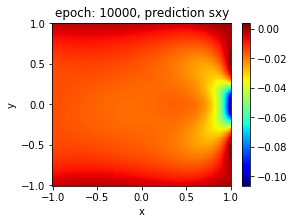

In [27]:
for epoch in range(num_epochs):
    
    optimizer.zero_grad()
    
    mse_losspde, _, _, _, _, _ = pinnLoss(x, y, mse, net_u, net_v)
    
    mse_lossbc = boundaryLoss(f, x, y, x0, y0, x1, y1, mse, net_u, net_v)
        
    loss = mse_losspde + mse_lossbc
    
    loss.backward(retain_graph = True)
    optimizer.step()
    
    item_obj = np.array([epoch+1, loss.item()])
    history_obj = np.vstack((history, item_obj))
    
    #with torch.autograd.no_grad():
    if (epoch+1) % 1000 == 0:
        print(epoch+1,"Traning Loss:",loss.item())            
        print(f'PDE Loss: {mse_losspde:.4e}, BC Loss: {mse_lossbc:.4e}') 
    if (epoch+1) % 1000 == 0:
        x_plt = np.linspace(x0,x1,200)
        y_plt = np.linspace(y0,y1,200)
        ms_x, ms_y = np.meshgrid(x_plt,y_plt)

        X = ms_x.reshape(-1,1)
        Y = ms_y.reshape(-1,1)

        pt_x = torch.tensor(X, requires_grad = True , dtype=torch.float32).to(device)
        pt_y = torch.tensor(Y, requires_grad = True , dtype=torch.float32).to(device)
        
        _, uPred, vPred, sxxPred, sxyPred, syyPred = pinnLoss(pt_x,pt_y, mse, net_u, net_v)
        
        ms_u = uPred.data.cpu().numpy().reshape(ms_x.shape)
        ms_v = vPred.data.cpu().numpy().reshape(ms_x.shape)            
        ms_sxx = sxxPred.data.cpu().numpy().reshape(ms_x.shape)
        ms_syy = syyPred.data.cpu().numpy().reshape(ms_x.shape)
        ms_sxy = sxyPred.data.cpu().numpy().reshape(ms_x.shape)

        ep = epoch + 1
        fig = plt.figure(figsize=(4,3))
        plt.pcolor(ms_x,ms_y,ms_u, cmap='jet')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.colorbar()
        plt.title(f"epoch: {ep}, prediction u")
        plt.show()

        fig = plt.figure(figsize=(4,3))
        plt.pcolor(ms_x,ms_y,ms_v, cmap='jet')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.colorbar()
        plt.title(f"epoch: {ep}, prediction v")
        plt.show()

        fig = plt.figure(figsize=(4,3))
        plt.pcolor(ms_x,ms_y,ms_sxx, cmap='jet')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.colorbar()
        plt.title(f"epoch: {ep}, prediction sxx")
        plt.show()

        fig = plt.figure(figsize=(4,3))
        plt.pcolor(ms_x,ms_y,ms_syy, cmap='jet')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.colorbar()
        plt.title(f"epoch: {ep}, prediction syy")
        plt.show()

        fig = plt.figure(figsize=(4,3))
        plt.pcolor(ms_x,ms_y,ms_sxy, cmap='jet')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.colorbar()
        plt.title(f"epoch: {ep}, prediction sxy")
        plt.show()